# Aligning and Translating a Beam with Steering Mirrors

This example works out how a beam can be shifted off-axis in FINESSE using a telescope, and verifies the analytical results derived in Simulating off-axis beams: calculating the shift with simulations in FINESSE:

## Optical Setup

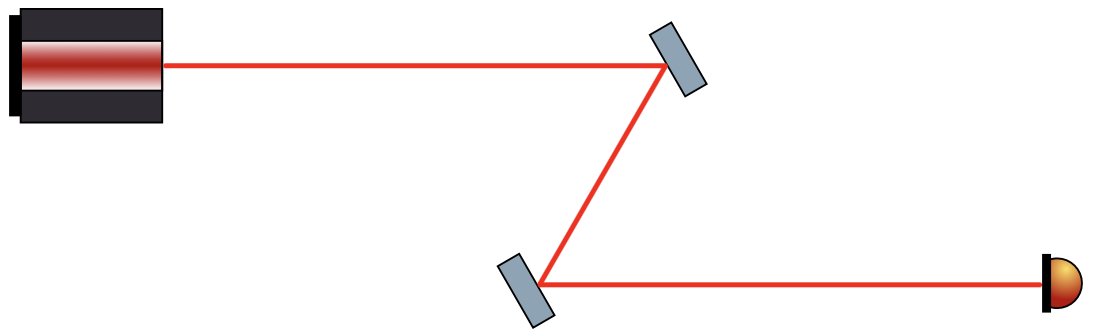

## Introduction

Given a Z-shaped telescope setup with two beamsplitters, we apply a small additional tilt $\beta$ to the angle of incidence $\alpha$ of both beamsplitters. This will cause the outgoing beam to shift over a small distance $\Delta$ with respect to the untilted step.

Such a small extra tilt is applied in FINESSE via the **xbeta** parameter of a **bs** component. With respect to the "untitled veam" (i.e. $\beta = 0$) we derive in section Simulating off-axis beams: calculating the shift both the shift in its position $\Delta$ and the change in its phase $\delta \phi$, each as a function of the angle $\beta$ and the distance $s$ between the beamsplitters. For the shift $\Delta$ we find that: $$\Delta = s \cdot \sin{2\beta}$$ while for the phase change $\delta \phi$ we derive: $$\delta\phi=\frac{2s\cdot\sin^2{\beta}}{\lambda}\cdot360\degree.$$

## Basic Setup

Our basic setup consists of:

* a **laser** with power 1.5 Watt
* two **beamsplitter** components, bs1 and bs2:
> * the first 1.9 km right of the laser, the second 400 metres away from the first
> * each having an angle of incidence $\alpha=30\degree$.
> * each tilted over a small angle $\beta=10^{-5}$ radians
* a Gaussian beam with waist-size $w_0=10$ mm, at a distance 1.2 km right of the laser, i.e. precisely in the middle between the two beamsplitters.
* we do most calculations using maxtem 7 (i.e. $n+m$ of the higher orders modes is $\le 7$.
* furthermore, the reference wavelength of FINESSE is $\lambda = 1064$ nm.

For these parameters, Eq 1 gives the following value for dimensionless $\Delta$ $$\frac{\Delta}{w_0} = \frac{400 \cdot \sin{\left(2\cdot 10^{-5}\right)}}{10^{-2}} \approx 0.8$$. while Eq 2 gives for $\delta \phi$, $$\delta\phi = \frac{2\cdot 400 \sin^2{10^{-5}}}{1.064 \cdot 10^{-6}} \cdot 360\degree \approx 27.1 \degree$$

Our basic FINESSE set up looks as follows.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import finesse
finesse.configure(plotting=True)

power = 1.5  # default laser power in Watt
w0 = 10e-3   # default gaussian waist size in meter3
alpha = 30   # angle of incidence for both BS in degrees0
xbeta = 1e-5 # default tilt of both beam splitters in radians
s1 = 1000    # distance till 1st beamsplitter
s2 = 400     # distance between beamsplitters
s3 = 600     # default distance between 2nd beamsplitter and detector
z0 = -1200   # default waist position, 1200 meter right of laser
maxtem = 7   # default maxtem

basescript = f"""
laser l1 P={power}
gauss g1 l1.p1.o w0={w0} z={z0}
modes(maxtem={maxtem})

space s1 l1.p1 bs1.p1 L={s1}
beamsplitter bs1 R=1 T=0 alpha={alpha} xbeta={xbeta}
space s2 bs1.p2 bs2.p1 L={s2}
beamsplitter bs2 R=1 T=0 alpha=bs1.alpha xbeta=bs1.xbeta
space s3 bs2.p2 n1.p1 L={s3}

# Add a 'nothing' component at the location of the detector
nothing n1
"""

basekat = finesse.Model()
basekat.parse(basescript)

## Measuring a Parallel Beam

We will use our experimental setup in combination with a 1-dimensional **ccdline** to measure the shape after 600 and 1000 metres respectively.

In [10]:
# Simulations: measure beam 600 and 1000 meter after second BS
s3a = 600
s3b = 1000

kat1 = finesse.Model()
kat1.parse(basescript)

script1 = f"""
# Set a 1-D CCD at n1, measure around peak at 0.8 at 600 and 1000m
ccdline ccd1 node=n1.p1.i xlim=[0.5,1.0] npts=200
# Also put a full 2-D CCD at the same position
ccd ccd2 node=n1.p1.i xlim=[-3,3] ylim=[-3,3] npts=200

series(
    noxaxis(name="S600"),
    change(s3.L={s3b}),
    noxaxis(name="S1000")
)
"""

kat1.parse(script1)
out1 = kat1.run()

We have also added a **ccd** of which we will use the output below to plot the 2-dimensional beam cross section. Plotting the output from the two 1-dimensional **ccdline** detectors.

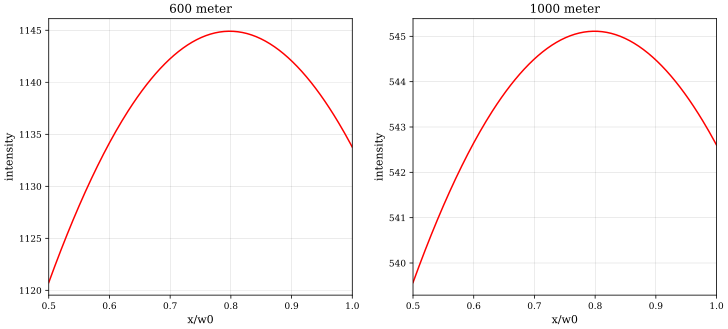

In [11]:
# Plot the results
f,ax = plt.subplots(ncols=2, figsize=(12, 5))
for (i, name, s3val) in ([0, 'S600', s3a], [1, 'S1000', s3b]):
    ax[i].plot(kat1.ccd1.xdata, out1[name]['ccd1'],'r')
    ax[i].set_title(f"{s3val:.0f} meter")
    ax[i].set_xlabel("x/w0")
    ax[i].set_ylabel("intensity")

we see that the Gaussian profile over distance becomes lower and wider, but remains its peak at the expected position $x/w_0=0.8$, confirming we are simulating a parallel but shifted beam.

For reference, we also plot the 2-dimensional beam cross section at 600 metres as measured with the **ccd**:

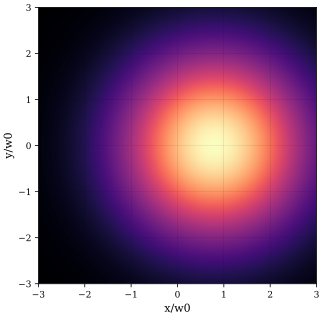

In [12]:
f,ax = plt.subplots(ncols=1, figsize=(5, 5))
pxy_extent = (kat1.ccd2.xdata.min(), kat1.ccd2.xdata.max(),
              kat1.ccd2.ydata.min(), kat1.ccd2.ydata.max())
ax.imshow(out1['S600']['ccd2'].T, aspect='auto', extent = pxy_extent)
ax.set_xlabel("x/w0")
ax.set_ylabel("y/w0");

## Measuring Phase Shift Across the Beam

We next measure the phase shift of the outgoing beam resulting from the tilting of the beamsplitters. For this we use the following simulation script (again in addition to the basic experimental setup), using a **fline** detector measuring the phase along the beam cross section at a distance 600 metres after the second beamsplitter. For reference, we also run the same simulation for $\beta=0$. We expect the full result to be shifted over $0.8w_0$ and to have a phase that is larger by about $27.1\degree$.

In [13]:
# Plotting range for x: [peak-dx...peak+dx]
dx = 0.8

# Calculate expected Delta and delta phi
Delta = s2*np.sin(2*xbeta)/w0
dphi = 2*s2*np.sin(xbeta)**2/basekat.lambda0*360

kat2 = finesse.Model()
kat2.parse(basescript)

script2 = f"""
fline fl1 node=n1.p1.i xlim=[{Delta}-{dx},{Delta}+{dx}] npts=200
fline fl2 node=n1.p1.i xlim=[-{dx},{dx}] npts=40

series(
    noxaxis(name='full'),
    change(bs1.xbeta=0),
    noxaxis(name='ref')
)
"""
kat2.parse(script2)
out2 = kat2.run()

We expect the phase for the shifted beam to satisfy $$\phi_{\beta=0} (x+\Delta) = \phi_{\beta=0}(x) + \delta \phi$$. In the plot below, we combine the result for the full simulation (red drawn line) with this expected result (blue points), obtained from translating the $\beta=0$ curve. It shows that the simulation matches the prediction perfectly.

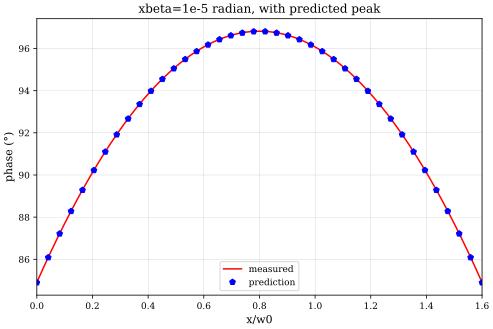

In [14]:
f,ax = plt.subplots(ncols=1, figsize=(8, 5))

ax.plot(kat2.fl1.xdata,
        np.angle(out2['full']['fl1'], deg=True),
        'r', label="measured")
ax.plot(kat2.fl2.xdata + Delta,
        np.angle(out2['ref']['fl2'], deg=True) + dphi,
        'bp', label="prediction")
ax.set_title("xbeta=1e-5 radian, with predicted peak")
ax.set_xlabel("x/w0")
ax.set_ylabel("phase (°)")
ax.legend(loc='lower center');

## Measuring Phase Shift Verses Tilt Angle

The expected phase dependence as a function of the tilt angle $\beta$ is given by Eq 2, which we can verify using an **ad** detector. We will use the following script.

In [15]:
kat3 = finesse.Model()
kat3.parse(basescript)

script3 = """
# Note: important to specify n,m
amplitude_detector ad1 node=n1.p1.i f=0 n=0 m=0
xaxis(bs1.xbeta, lin, -1.5e-5, 1.5e-5, 40)
"""

kat3.parse(script3)
out3 = kat3.run()

and plot the result together with the expected behaviour Eq. 2. Note that we now have to grab the horizontal data from the **ArraySolution** object (*out3*) instead of from the **Model** object (*kat3*) since for this **ad** detector we use an **xaxis** instead of a **noxaxis** action. Again we see that the simulation matches perfectly with the prediction.

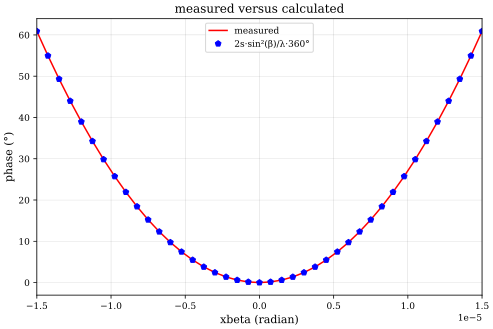

In [16]:
f,ax = plt.subplots(ncols=1, figsize=(8, 5))

ax.plot(out3.x[0], np.angle(out3['ad1'], deg=True),
        'r', label="measured")
ax.plot(out3.x[0], 2*s2*np.sin(out3.x[0])**2/basekat.lambda0*360,
        'bp', label="2s·sin²(β)/λ·360°")
ax.set_title("measured versus calculated")
ax.set_xlabel("xbeta (radian)")
ax.set_ylabel("phase (°)")
ax.legend(loc="upper center");